### Credit Valuation Adjustment

In [2]:
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
### Initialize problem parameters
# option maturity
T = 1
# current share price
S0 = 100
# strike price, at-the-money
K = 110
# risk-free rate
r = .1
# volatility
sigma = .3

# counterparty's value
v_c = 200
# volatility for the counterparty's firm
sigma_c = .25
# counterparty's debt, due in one year 
debt = 180
# recovery rate
delta = 0.2

########
sample_size = 50000 
np.random.seed(0) # to compare value to lecture examples

In [23]:
# since this is a call option, we only care about terminal value.
# But the same can be calculated at any time point
def value(S, r, sigma, t, Z): # applies to both firm and stock
    return S*np.exp((r - sigma**2/2)*t + sigma*np.sqrt(t)*Z)

In [7]:
def payoff(S_T, K): # payoff for European Call options
    return np.maximum(S_T - K, 0)

In [24]:
# set up different corr values
corr_tested = np.linspace(-1, 1, 21)
cva_estimates = []
cva_std = []

In [25]:
for corr in corr_tested:
    if abs(corr) == 1: # then the matrix is not positive definite, hence cannot do Cholesky decomp.
        norm_vec_0 = stats.norm.rvs(size = sample_size)
        norm_vec_1 = corr * norm_vec_0
        corr_norm_matrix = np.array([norm_vec_0, norm_vec_1])
    else: # do Cholesky decomp.
        corr_matrix = np.array([[1, corr], [corr, 1]])
        norm_matrix = stats.norm.rvs(size = np.array([2, sample_size]))
        L = np.linalg.cholesky(corr_matrix)
        corr_norm_matrix = np.matmul(L, norm_matrix)
    
    stock_val = value(S0, r, sigma, T, corr_norm_matrix[0,])
    call_val = payoff(stock_val, K)
    
    firm_val = value(v_c, r, sigma_c, T, corr_norm_matrix[1,])
    amount_lost = np.exp(-r*T) * (1-delta) * (firm_val < debt) * call_val
    
    cva_estimates.append(np.mean(amount_lost))
    cva_std.append(np.std(amount_lost) / np.sqrt(sample_size))

In [26]:
# little helper function to calculate d1 and d2 in BSM
def d1(S0, r, sigma, K, T, t=0):
    return (np.log(S0/K) + (r + sigma**2/2)*(T-t))/ (sigma*np.sqrt(T-t))
def d2(S0, r, sigma, K, T, t=0, d_1=None):
    if not d_1:
        d_1 = d1(S0, r, sigma, K, T, t)
    return d_1 - sigma*np.sqrt(T-t)

In [27]:
# calculate default probability
d2_c = d2(v_c, r, sigma_c, debt, T) # at t=0
default_prob = stats.norm.cdf(-d2_c)

In [28]:
# calculate analytical solution for callprice at t=0
d1_stock = d1(S0, r, sigma, K, T)
d2_stock = d2(S0, r, sigma, K, T, d_1 = d1_stock)

phi = stats.norm.cdf
analytical_callprice = S0*phi(d1_stock) - K*np.exp(-r*T)*phi(d2_stock)

In [29]:
# calculate CVA providing no correlation
uncorr_cva = (1-delta)*analytical_callprice*default_prob

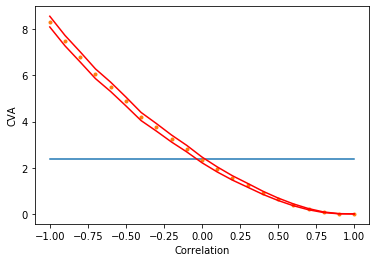

In [30]:
# plotting against different values of correlations
plt.plot(corr_tested, [uncorr_cva]*21)
plt.plot(corr_tested, cva_estimates, '.')
plt.plot(corr_tested, cva_estimates + 3*np.array(cva_std), 'r')
plt.plot(corr_tested, cva_estimates - 3*np.array(cva_std), 'r')
plt.xlabel('Correlation')
plt.ylabel('CVA')
plt.show()